# Noise ceiling tutorial

By Beau Sievers • http://beausievers.com/ • http://twitter.com/beausievers/

## What is a noise ceiling?

Imagine: You have painstakingly collected data for a scientific experiment. You have a hypothesis about the data, formalized as statistical model. When you train and test your model, you find that it predicts the data to an apparently reasonable degree of accuracy. "Success!" you exclaim, ready to embrace your future fame and glory. But when you are alone, at night, you begin to worry. "But is my model really the _best_ model?" you mutter anxiously. How much variance have you left unexplained? You lose sleep over this question. Surely it's not possible for _any_ model to predict the data perfectly, because it contains _noise:_ uninteresting variance caused by, for example, measurement error. "There must be some way," you say to yourself, "to evaluate how good my model is given the amount of noise in my data?" Friend, what you want—what you need!—is to calculate the _noise ceiling._

The noise ceiling is the performance of the best possible model of the data, which we estimate using the data itself, assuming all of the variance across samples is noise. Let's look at an example.

## An imaginary experiment

Say you're measuring how hard it is to remember nonsense words, and you hypothesize that the longer the word is, the harder it will be to remember. Each participant studies a list of nonsense words, with 10 words of each length, and is tested on their memory.

Your hypothesis is that the longer the word, the less likely people will be to remember it, with performance peaking at length 2 and dropping to zero by length 12. On the other hand, one of your colleagues believes that medium length words are remembered best, and that both short and long words are hard to remember. The goal of this experiment is to see which of these two models is the better fit. 

Because this is an imaginary experiment, your model is in fact the true model, and your colleague is completely, utterly wrong.

Let's plot both models:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings; warnings.simplefilter('ignore')  # For demonstration purposes only

sns.set(font_scale=1.5)
sns.set_style('ticks')

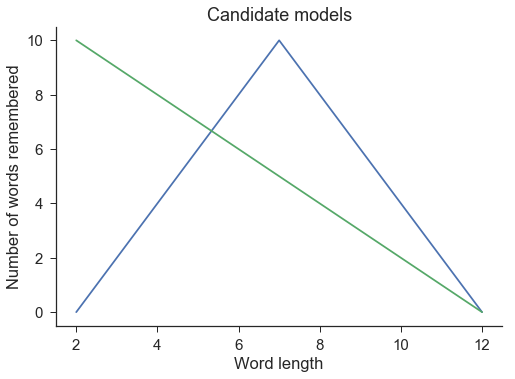

In [2]:
word_lengths = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
your_colleagues_model = np.array([0, 2, 4, 6, 8, 10, 8, 6, 4, 2, 0])
your_model = np.array([10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

plt.plot(word_lengths, your_colleagues_model)
plt.plot(word_lengths, your_model)
plt.xlabel("Word length")
plt.ylabel("Number of words remembered")
plt.title("Candidate models");
sns.despine()

In contrast to the purity of these models, participants' actual performance on the memory test is noisy. For unknown and innumerable reasons—including their second-to-second level of anxiety, tendency to mind wander, and so on—each participant's results are a little bit off. In fact, sometimes they are _way_ off.

In [3]:
def test_participant(true_word_lengths, true_memory_probabilities, noise_mean=0, noise_std=7):
    noise = np.random.normal(loc=noise_mean, scale=noise_std, size=true_memory_probabilities.shape[0])
    response = true_memory_probabilities + noise
    response = np.clip(response, 0, 10)  # Because there are only 10 words in each category
    return response

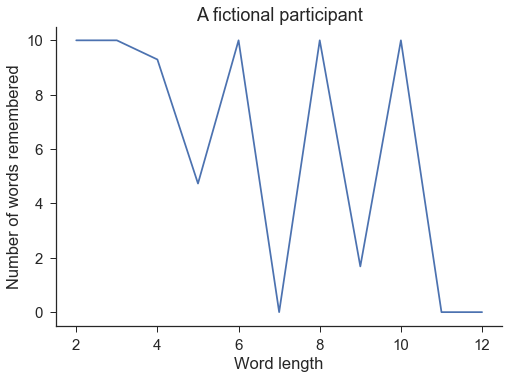

In [4]:
participant_response = test_participant(word_lengths, your_model)

plt.plot(word_lengths, participant_response)
plt.xlabel("Word length")
plt.ylabel("Number of words remembered")
plt.title("A fictional participant")
sns.despine()

We assess the fit of this participant's data to our model using Pearson correlation:

In [5]:
def test_model(model, data):
    from scipy.stats import pearsonr
    return pearsonr(model, data)

In [6]:
test_model(your_model, participant_response)

(0.6053792542154564, 0.04842288804134243)

In [7]:
test_model(your_colleagues_model, participant_response)

(-0.019176242230153847, 0.9553728402749465)

Let's assume there are 40 participants in your study, and test our models on each of them.

In [8]:
n_participants = 40
participant_responses = np.array(
    [test_participant(word_lengths, your_model) for _ in range(n_participants)]
)
your_model_fits = np.array(
    [test_model(your_model, response)[0] for response in participant_responses]
)
colleague_model_fits = np.array(
    [test_model(your_colleagues_model, response)[0] for response in participant_responses]
)
print(f"Mean model fit, your model: {your_model_fits.mean().round(2)}")
print(f"Mean model fit, colleague's model: {colleague_model_fits.mean().round(2)}")

Mean model fit, your model: 0.41
Mean model fit, colleague's model: 0.01


In [9]:
df = pd.DataFrame({
    'Your model': your_model_fits,
    "Colleague's model": colleague_model_fits
})
df = pd.melt(df, var_name='Model', value_name='Fit')

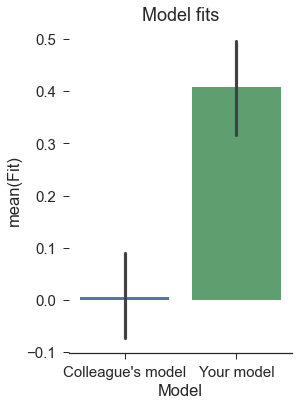

In [10]:
plt.subplots(figsize=(4, 6))
sns.barplot(x='Model', y='Fit', data=df)
plt.title(f"Model fits")
sns.despine(left=True)

This looks good, you tell yourself, but then there you are, sitting alone at night, contemplating failure. You've outperformed your colleague—but are you _right?_ Given the noise in the data, how would the true model perform? It's time to calculate the noise ceiling.

## Calculating the noise ceiling

Here we'll walk through how to calculate the noise ceiling step-by-step to see how it works, then we'll generalize it into a function we can reuse in the next section.

If we assume that the only source of variance between participants is noise, then the best fitting model for the data is simply the mean.

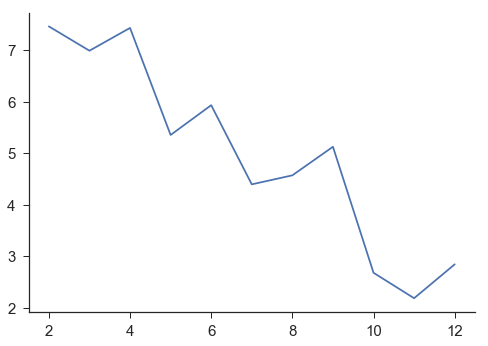

In [11]:
best_fit = participant_responses.mean(axis=0)
plt.plot(word_lengths, best_fit);
sns.despine()

We then test this model on each participant's responses, just as we did with the true model earlier.

In [12]:
noise_ceiling_model_fits = np.array(
    [test_model(best_fit, response)[0] for response in participant_responses]
)
noise_ceiling_upper_bound = noise_ceiling_model_fits.mean()
noise_ceiling_upper_bound

0.43938756480089386

This is the _upper bound_ of the noise ceiling. Because simply taking the mean uses all of the data to estimate the central tendency, we are in effect overfitting the data as thoroughly as possible. No model should perform meaningfully above this ceiling.

To get a _lower bound_ of the noise ceiling, we try to find the central tendency of the data without overfitting. To do this, we use a leave-one-out cross-validation procedure. We cycle through our data set once per participant, leaving that participant out, calculating the mean for everyone still left in, and then testing the correlation of the left-out participant's data with the left-in mean. The mean of these correlations is an unbiased estimate of our noise ceiling's lower bound.

In [13]:
from scipy.stats import pearsonr

correlations = list()
for i in range(participant_responses.shape[0]):
    participant_left_out = participant_responses[i]
    left_in_indexes = np.repeat([True], participant_responses.shape[0])
    left_in_indexes[i] = False
    left_in = participant_responses[left_in_indexes]
    left_in_mean = left_in.mean(axis=0)
    correlations.append(pearsonr(participant_left_out, left_in_mean)[0])

noise_ceiling_lower_bound = np.mean(correlations)
noise_ceiling_lower_bound

0.39797729129968396

Now we can see that the performance of your model—the true model!—is well within the bounds of the noise ceiling (the blue shaded region, below). Nobody could possibly do better than this, so you can sleep peacefully tonight.

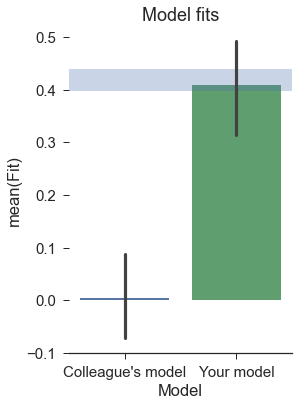

In [14]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.barplot(x='Model', y='Fit', data=df)
ax.axhspan(noise_ceiling_lower_bound, noise_ceiling_upper_bound, alpha=.3)
plt.title(f"Model fits")
sns.despine(left=True)

## Noise ceiling function

### An important cautionary note

This way of calculating the noise ceiling is specific to the correlational analysis used in this tutorial. If you are using a different type of analysis, you would need to calculate the noise ceiling in a way that is matched to your procedure. For example, if you are using Spearman (ranked) correlation in your analyses, you would need to ensure your noise ceiling calculations also used Spearman correlation. For more complicated analyses, it can be very difficult to figure out an appropriate way to calculate the "best fitting" model from your data. For example, if your model takes individual differences into account, so the variability is explicitly _not_ just noise, calculating the noise ceiling in a reasonable way can be tricky. (More on this in the next tutorial?)

In [15]:
def noise_ceiling(data):
    """Calculate the lower and upper bounds of the noise ceiling.
    
    Args:
        data (numpy.array): Your data, samples-by-features.
    """
    from scipy.stats import pearsonr
    
    best_fit = data.mean(axis=0)
    sample_fits = np.array([test_model(best_fit, sample)[0] for sample in data])
    upper_bound = sample_fits.mean()
    
    correlations = list()
    for i in range(data.shape[0]):
        sample_left_out = data[i]
        left_in_indexes = np.repeat([True], data.shape[0])
        left_in_indexes[i] = False
        left_in = data[left_in_indexes]
        left_in_mean = left_in.mean(axis=0)
        correlations.append(pearsonr(sample_left_out, left_in_mean)[0])

    lower_bound = np.mean(correlations)
    
    return (lower_bound, upper_bound)

## Performance at different levels of noise

The noisier the data, the lower the ceiling, and the wider the difference between the upper and lower bounds.

In [16]:
def simulation(word_lengths, true_model, n_participants, noise_mean, noise_sd):
    participant_responses = np.array(
        [test_participant(word_lengths, true_model, noise_mean, noise_sd) for _ in range(n_participants)]
    )
    model_fits = np.array(
        [test_model(your_model, response)[0] for response in participant_responses]
    )
    return model_fits, noise_ceiling(participant_responses)

In [17]:
n_participants = 40
noise_sds = np.linspace(0, 20, 21)
simulations_noise = [simulation(word_lengths, your_model, n_participants, 0, sd) for sd in noise_sds]

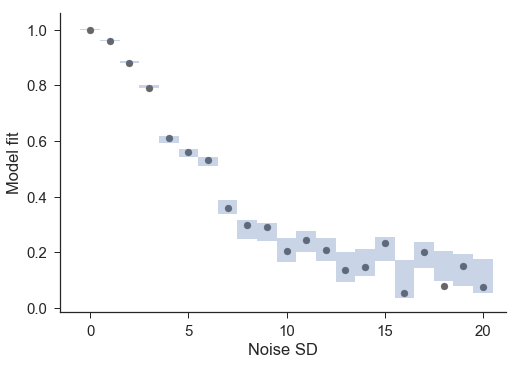

In [18]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots()
for sim, noise_sd in zip(simulations_noise, noise_sds):
    plt.scatter(noise_sd, np.mean(sim[0]), color='#666666')
    ceiling_height = sim[1][1] - sim[1][0]
    if ceiling_height < .0001:
        ceiling_height = .001  # always plot _something_
    ax.add_patch(Rectangle((noise_sd - .5, sim[1][0]), 1, ceiling_height, alpha=.3))

plt.xlabel("Noise SD")
plt.ylabel("Model fit")
sns.despine()

## Performance with different sample sizes

The lower the sample size, the wider the difference between the upper and lower bounds.

In [19]:
sample_sizes = np.linspace(0, 100, 21)
simulations_n = [simulation(word_lengths, your_model, int(n), 0, 5) for n in sample_sizes]

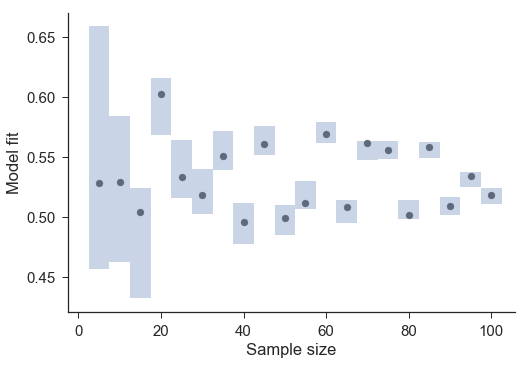

In [20]:
fig, ax = plt.subplots()
for sim, n in zip(simulations_n, sample_sizes):
    plt.scatter(n, np.mean(sim[0]), color='#666666')
    ax.add_patch(Rectangle((n-2.5, sim[1][0]), 5, sim[1][1] - sim[1][0], alpha=.3))

plt.xlabel("Sample size")
plt.ylabel("Model fit")
sns.despine()

## Conclusion

Now that you can calculate the noise ceiling, you no longer need to worry about whether or not your model is bad. Instead, you can quantify exactly how bad it is. Thanks for reading.

## References

Nili, H., Wingfield, C., Walther, A., Su, L., Marslen-Wilson, W., & Kriegeskorte, N. (2014). A toolbox for representational similarity analysis. PLoS computational biology, 10(4), e1003553. http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003553